In [159]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import statsmodels.api as sm


import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [160]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [161]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Scale the skier numbers

In [162]:
ref_column = 'skiers'
sc_skiers = scale_skiers(df, (0,100), ref_column)
sc_skiers = [round(crowd, 0) for crowd in sc_skiers]
df['skiers'] = sc_skiers

In [163]:
features = list(df.columns.values)
features.remove('skiers')

412

### Create a training and holdout set

In [165]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
#df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2015,5,1):]
df_cv = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]

## Forward selection

In [166]:
lin_regr = linear_model.LinearRegression()

In [167]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [168]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [169]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos].skiers
y_tr_apr = df_tr.iloc[apr_pos].skiers

In [170]:
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [171]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  open_lifts_sq , RMSE:  19.6 #: 1
Next best Feature:  open_percent_midweek_sqrt , RMSE:  17.2 #: 2
Next best Feature:  month_4 , RMSE:  16.6 #: 3
Next best Feature:  day_0 , RMSE:  15.4 #: 4
Next best Feature:  days_since_start_xmas_sq , RMSE:  13.0 #: 5
Next best Feature:  days_since_start_midweek_sq , RMSE:  12.5 #: 6
Next best Feature:  open_percent , RMSE:  12.3 #: 7
Next best Feature:  4day_snow_tot_sat_sqrt , RMSE:  12.0 #: 8
Next best Feature:  month_4_mon , RMSE:  11.9 #: 9
Next best Feature:  day_0_spring_break , RMSE:  11.9 #: 10
Next best Feature:  4day_snow_tot_spring_break_sqrt , RMSE:  11.9 #: 11
Next best Feature:  open_trails_mon_sq , RMSE:  11.7 #: 12
Next best Feature:  mlk_day , RMSE:  11.6 #: 13
Next best Feature:  thanksgiv_midweek , RMSE:  11.4 #: 14
Next best Feature:  ln_tot_snow_midweek , RMSE:  11.4 #: 15
Next best Feature:  before_xmas_midweek , RMSE:  11.2 #: 16
Next best Feature:  2day_snow_tot_sat , RMSE:  11.2 #: 17
Next best Feature:  

#### Plot the change in error with each additional feature.

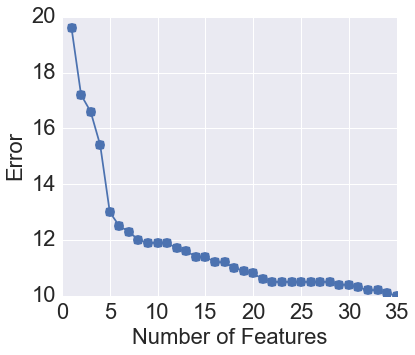

In [172]:
plot_error_vs_features(RMSE, 'none', 'none')

#### Plot the cv fit and learning curve at each step.

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


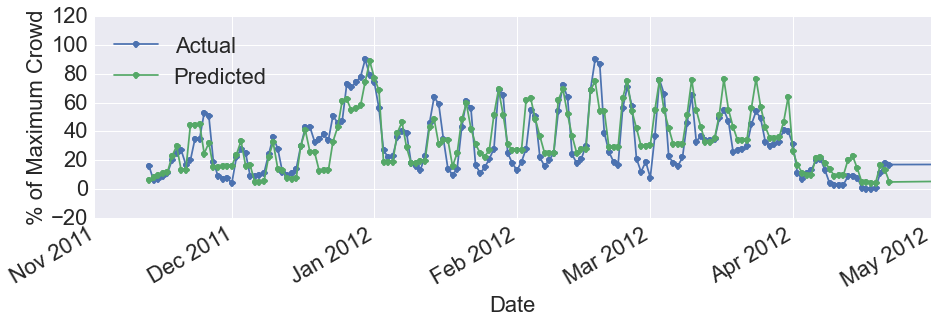

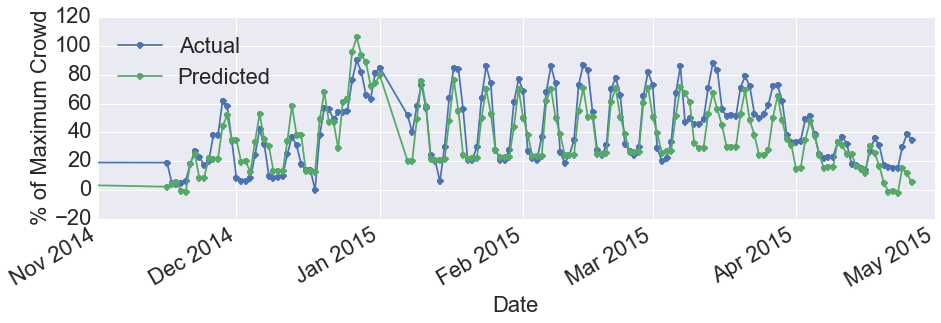

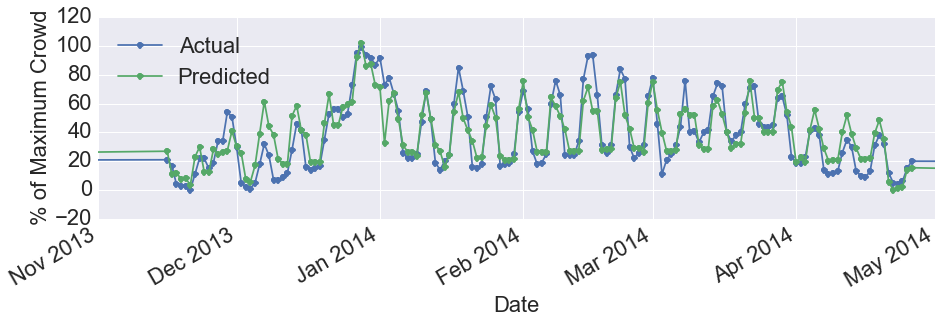

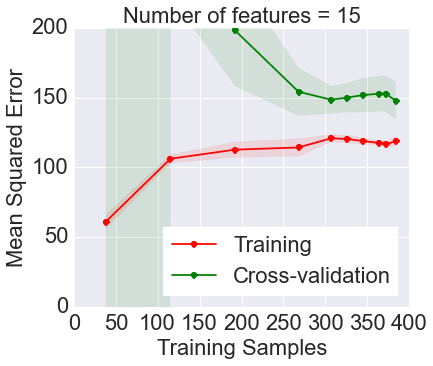

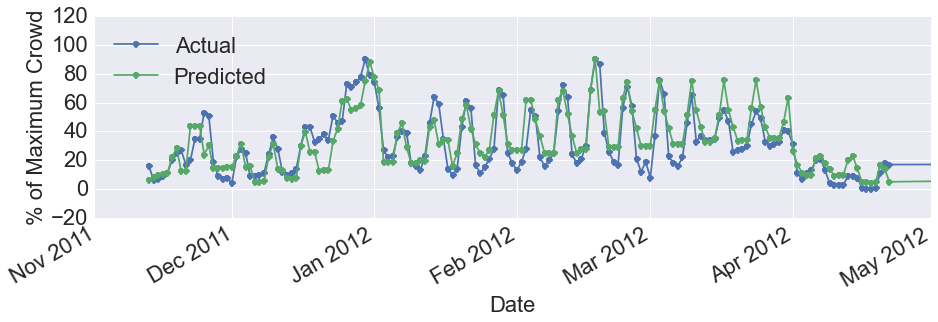

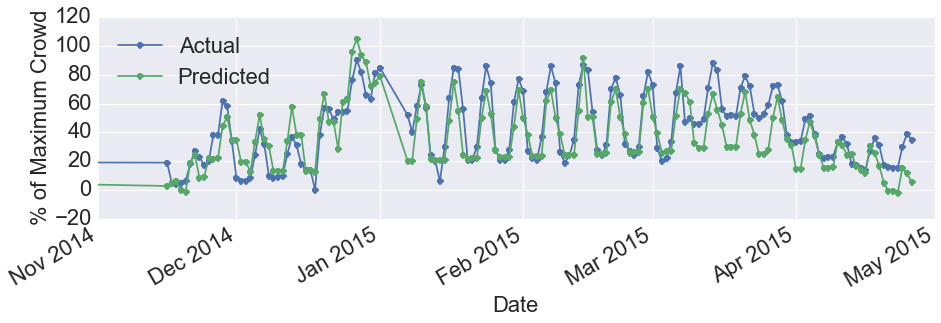

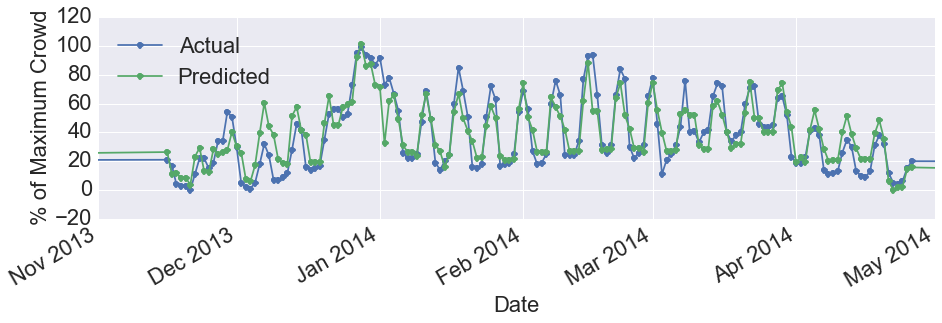

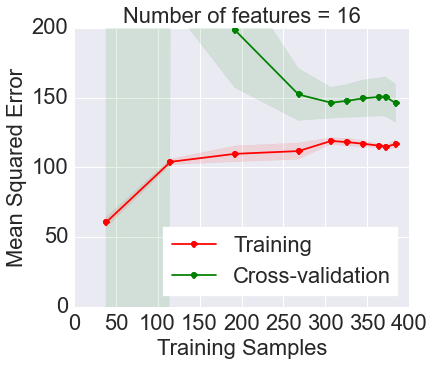

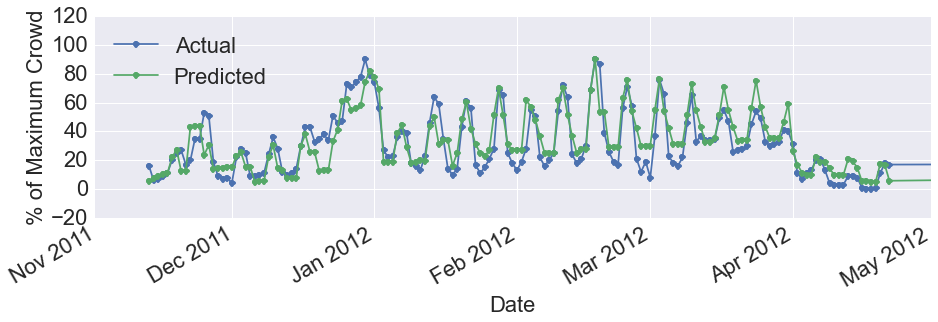

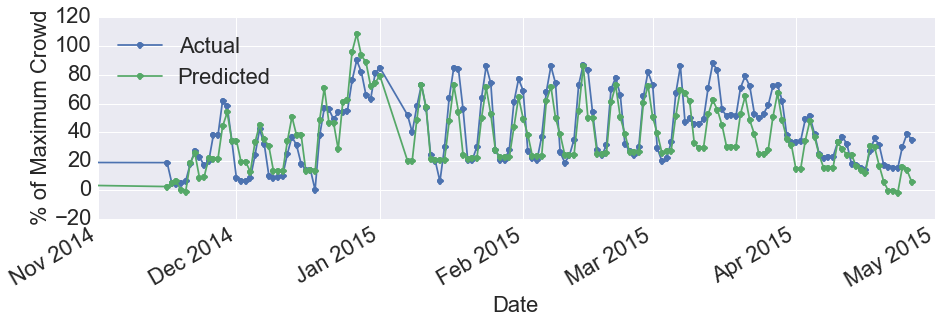

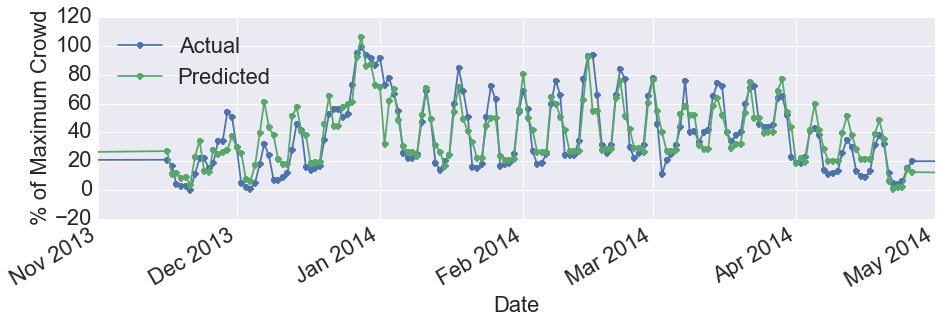

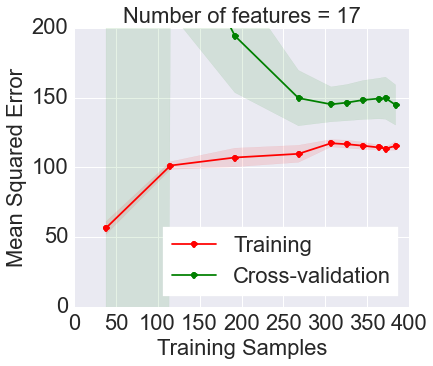

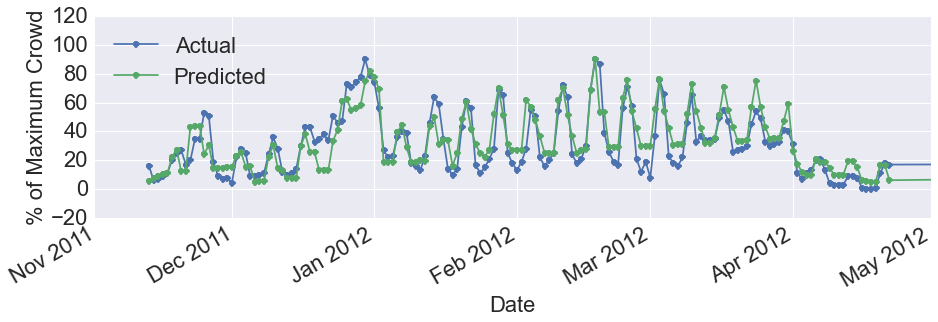

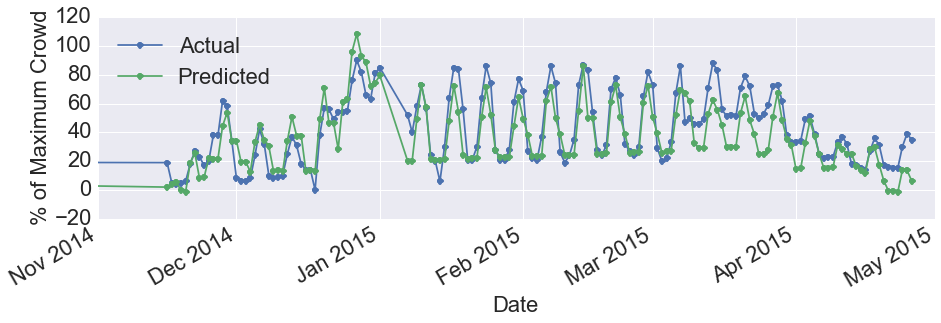

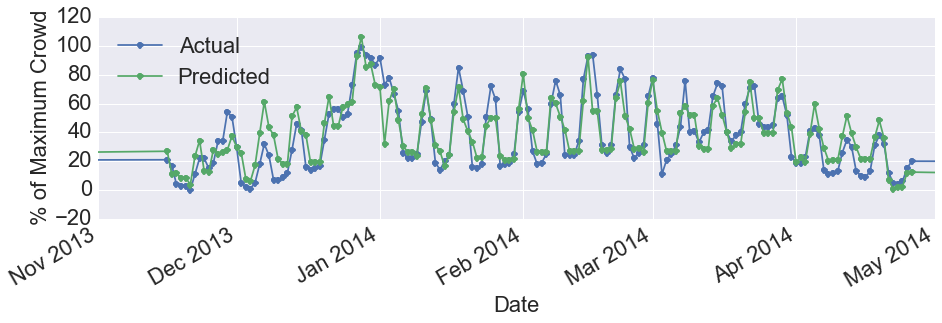

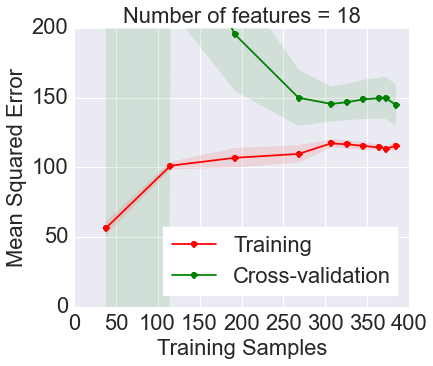

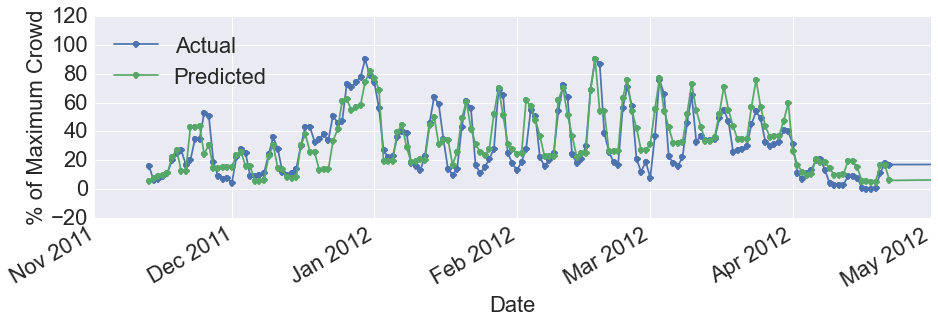

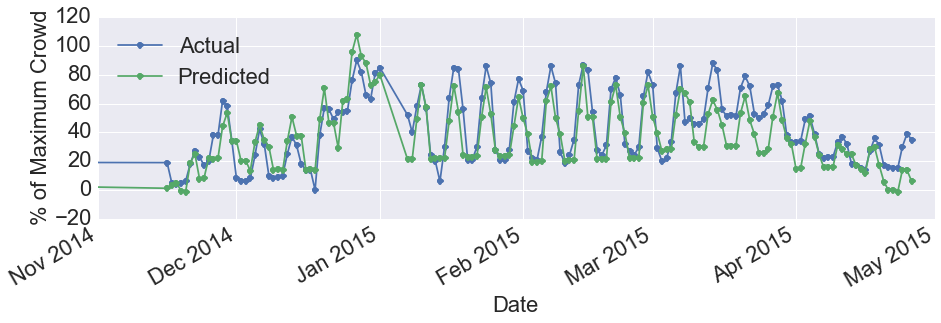

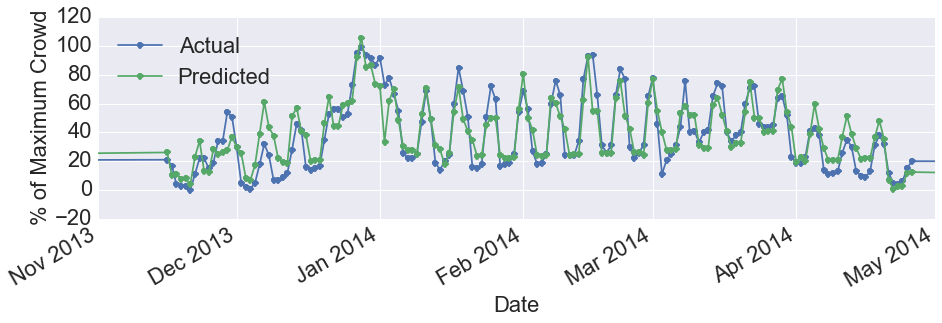

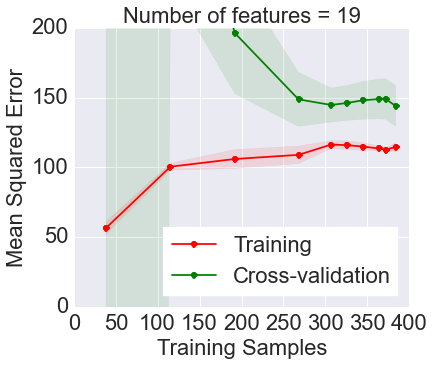

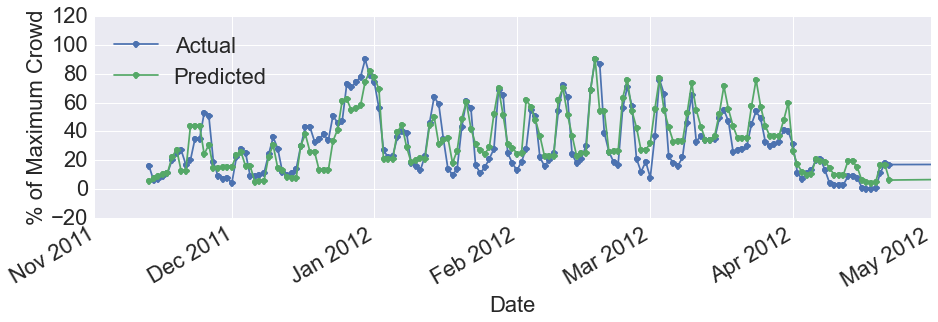

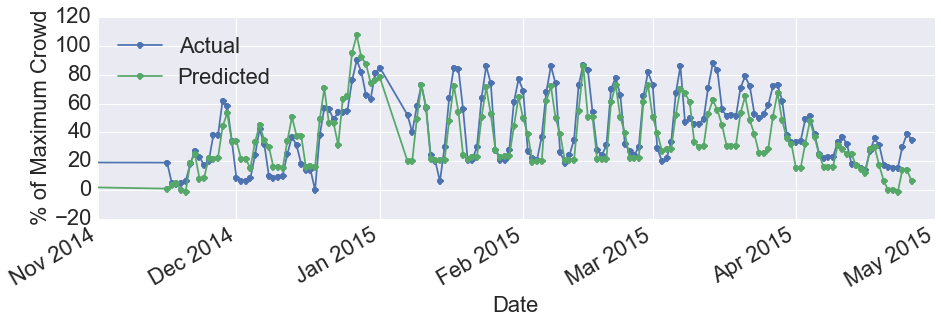

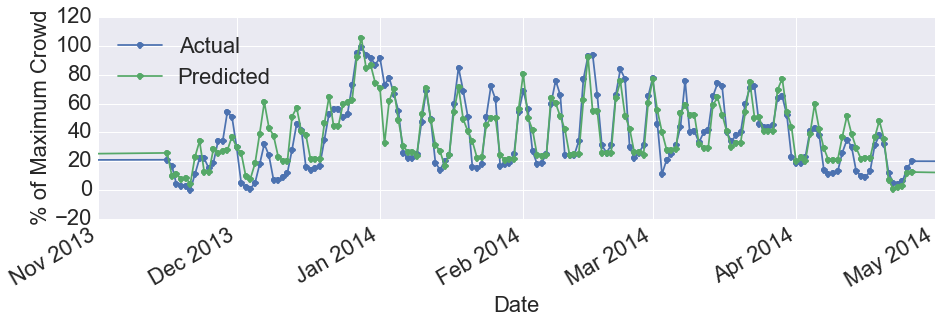

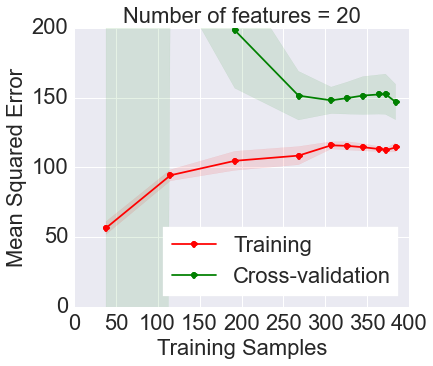

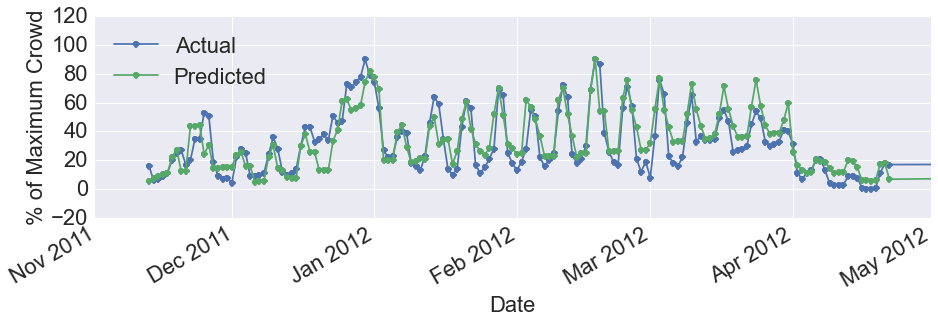

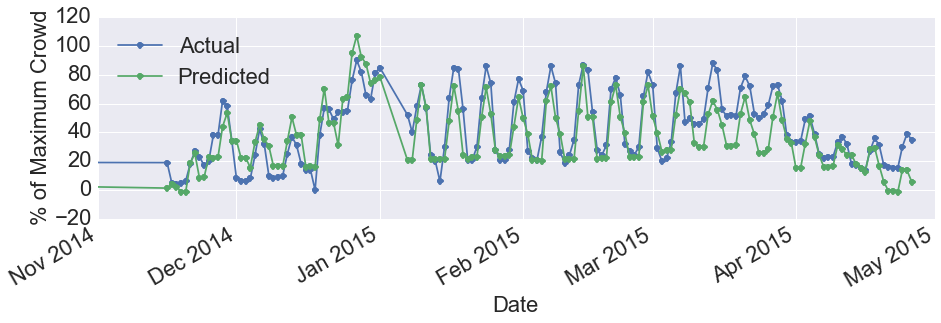

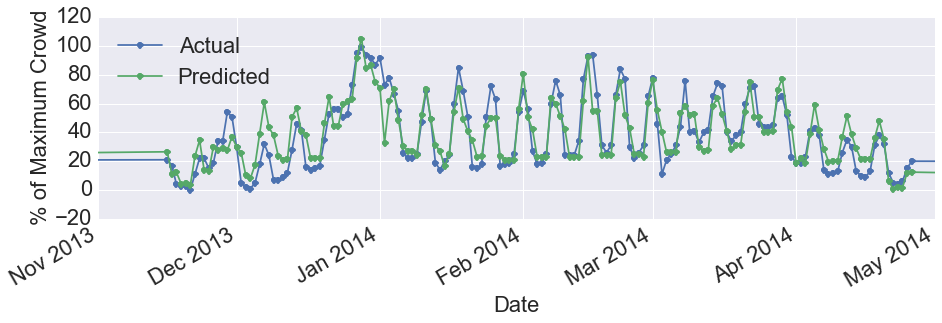

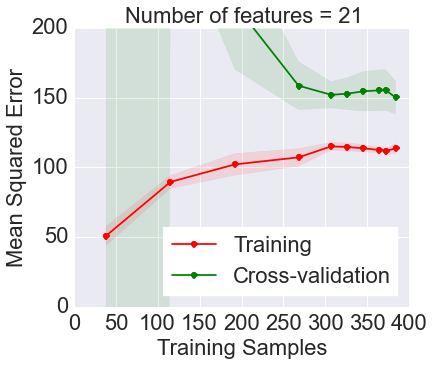

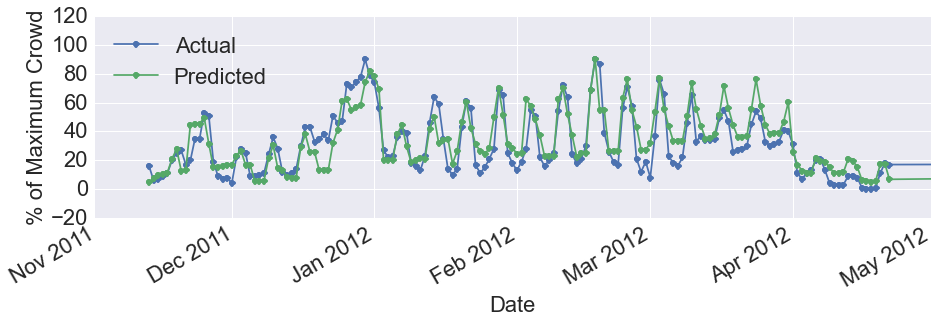

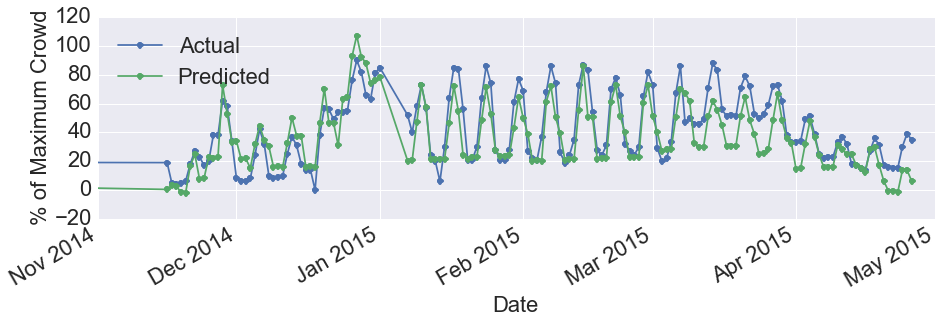

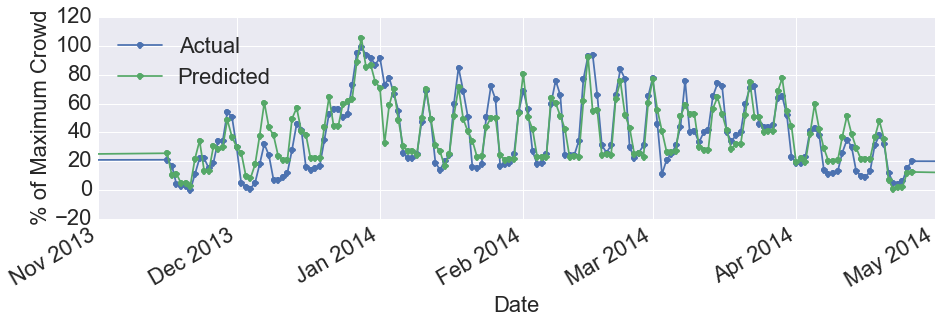

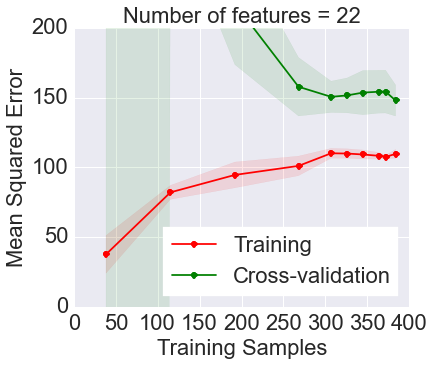

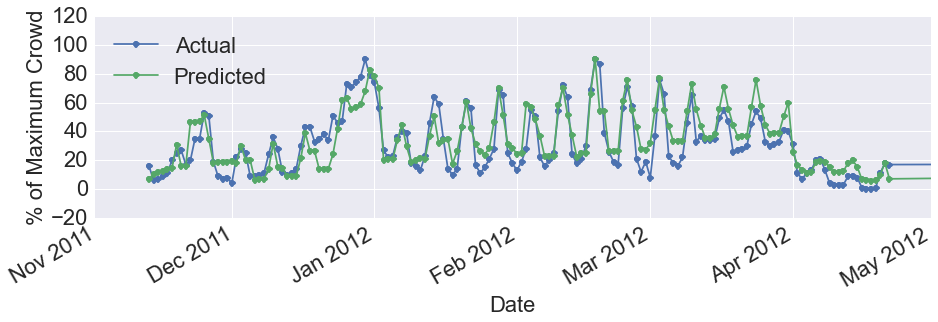

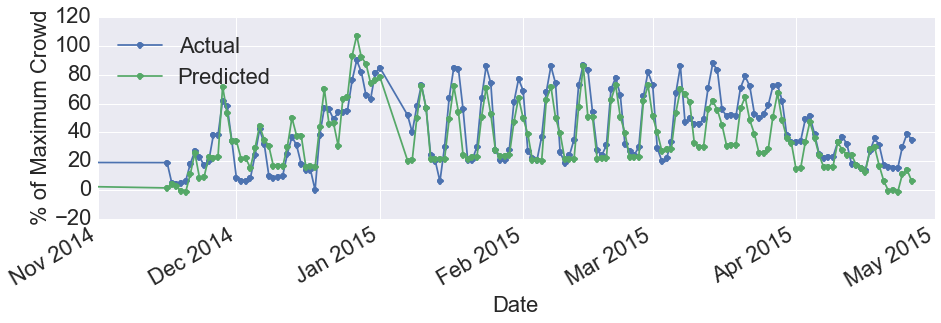

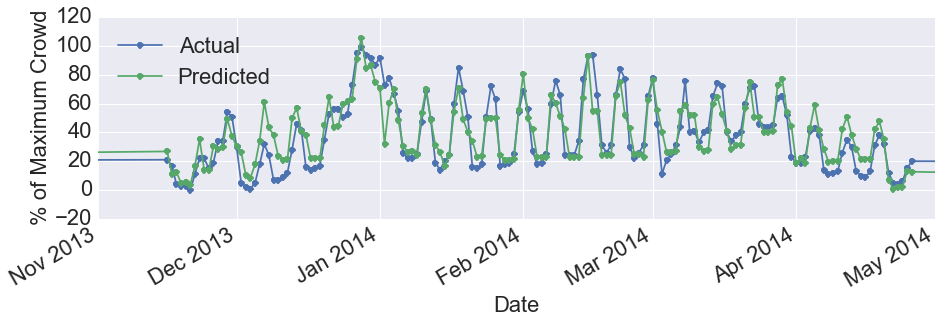

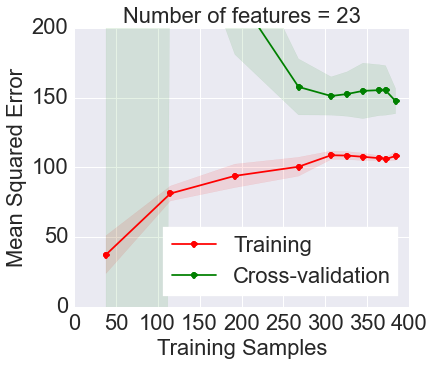

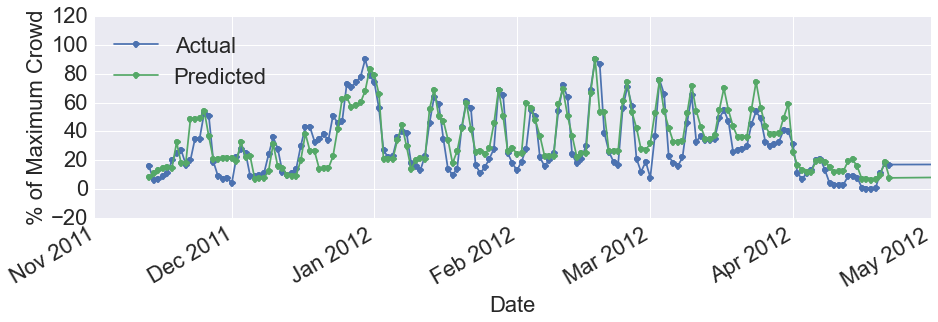

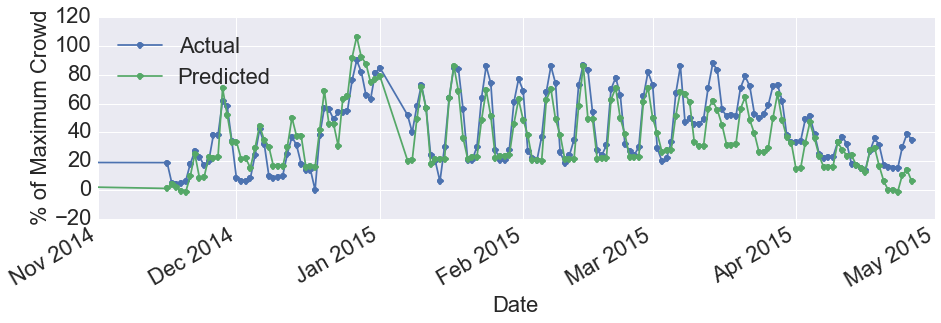

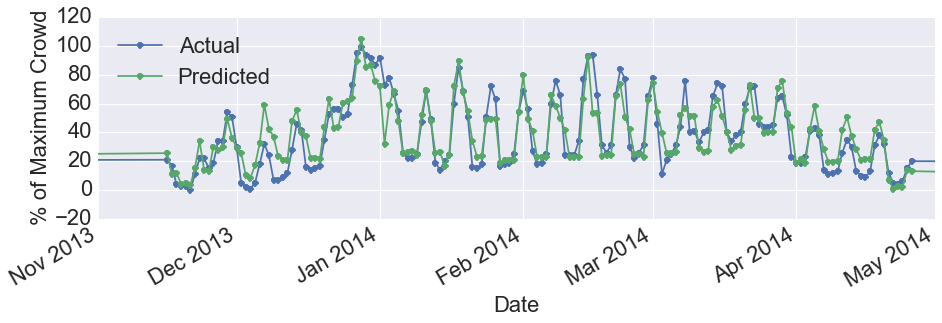

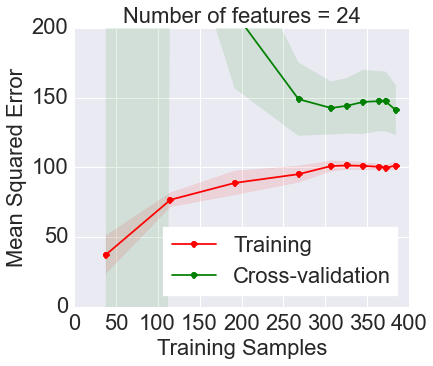

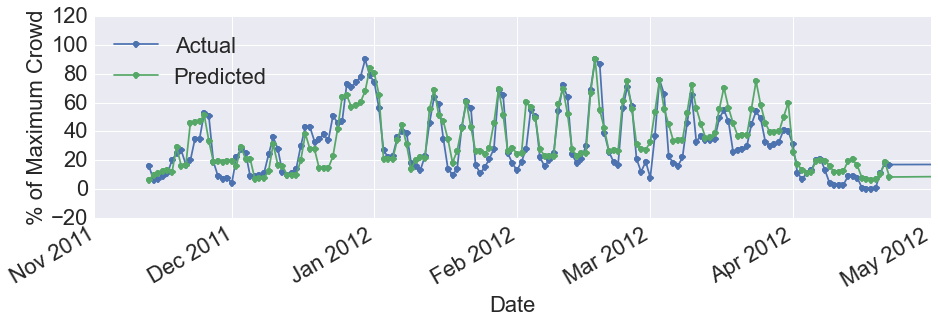

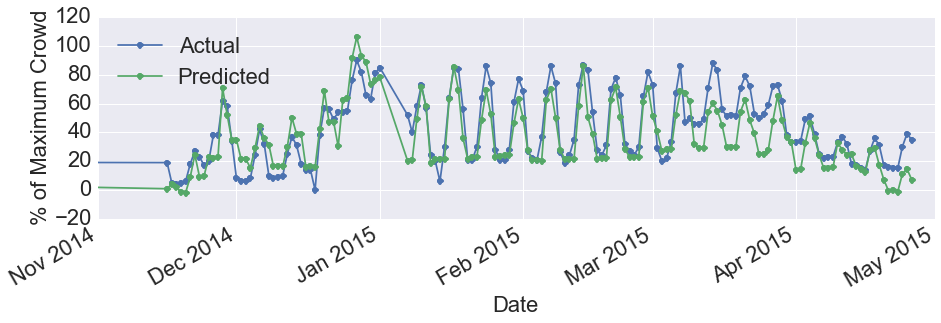

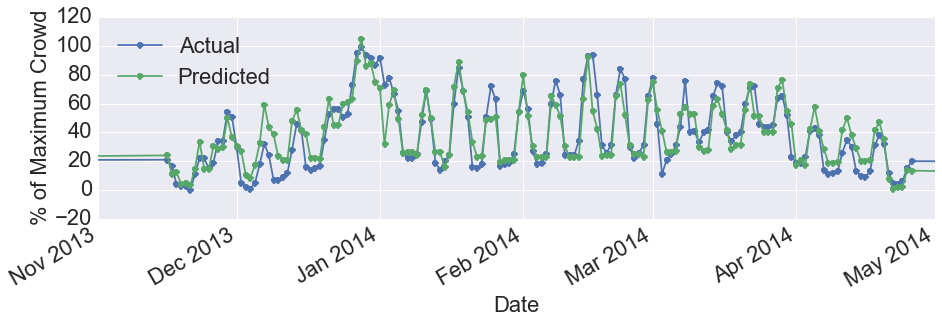

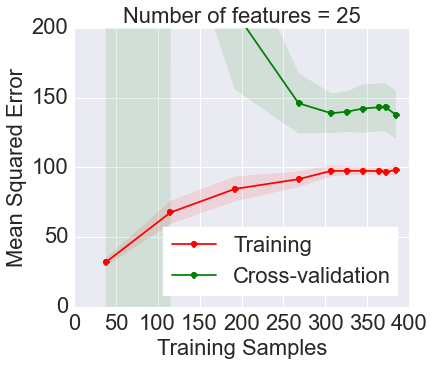

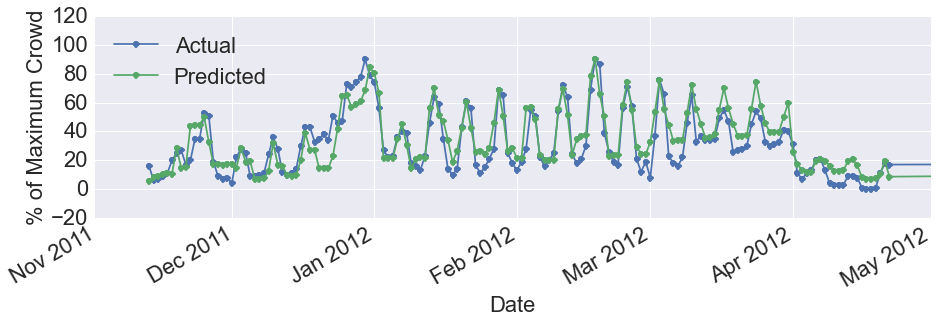

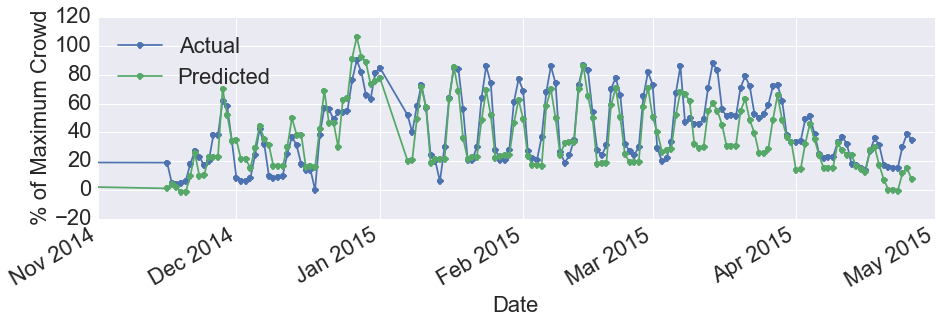

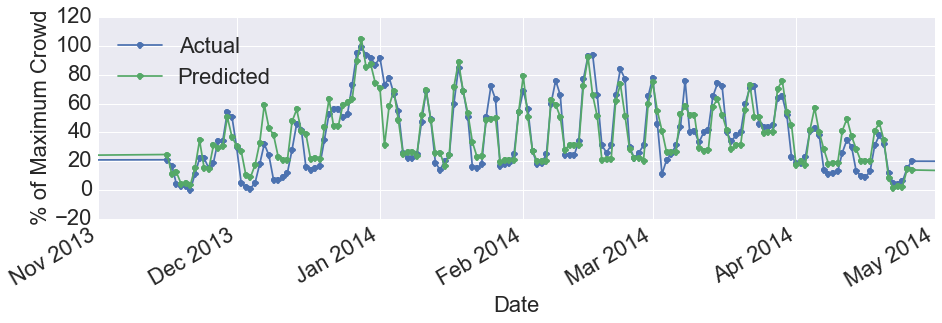

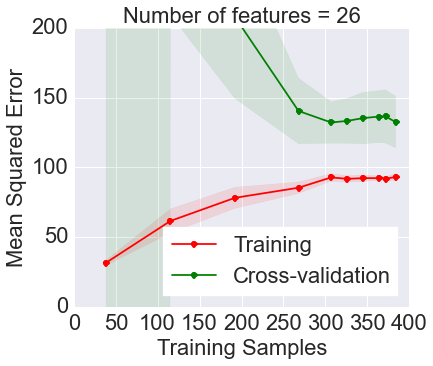

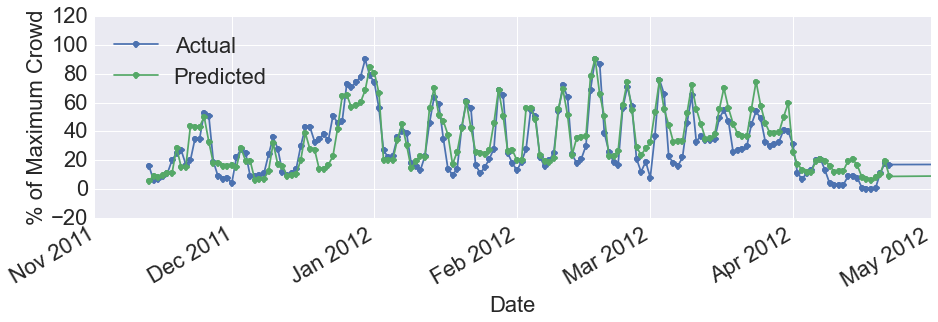

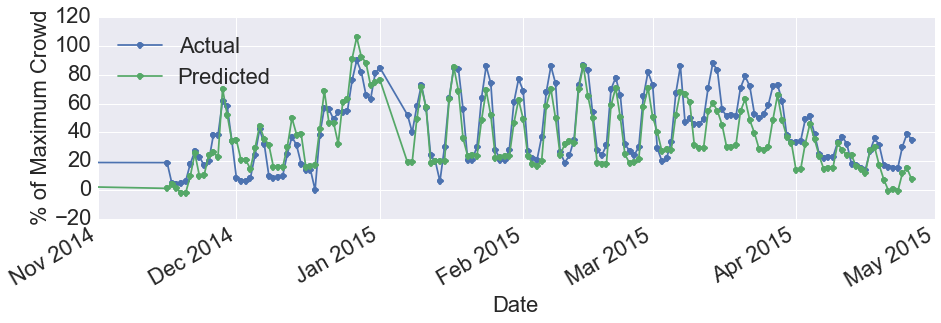

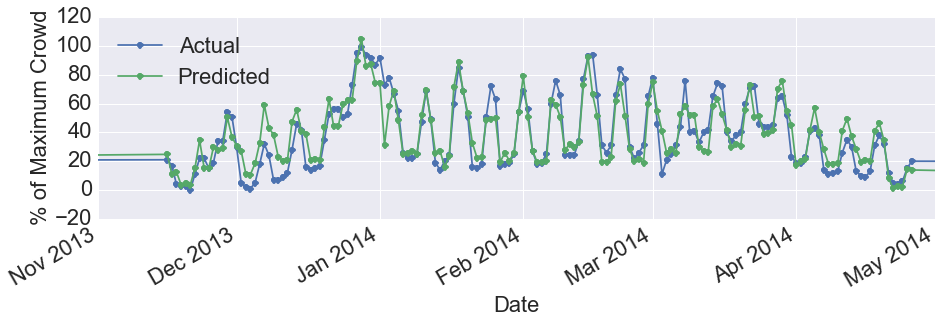

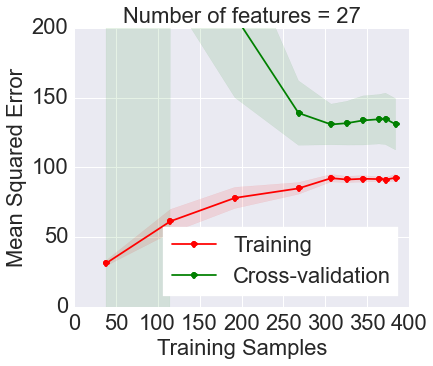

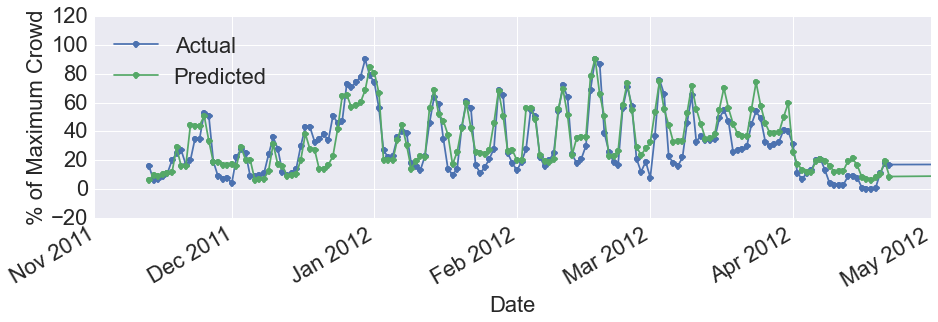

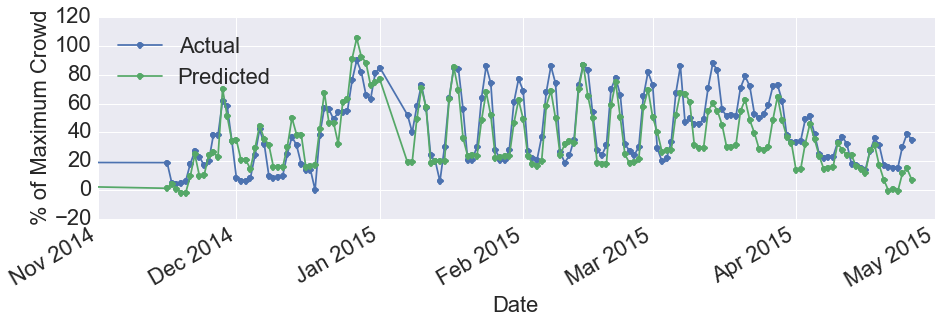

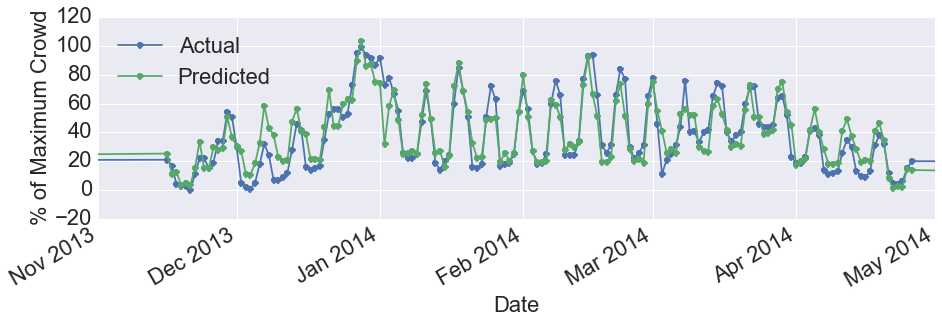

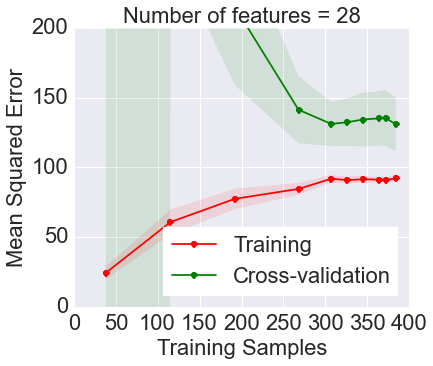

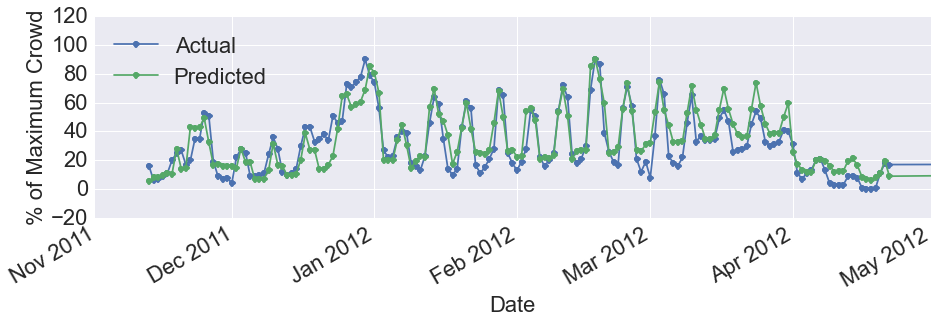

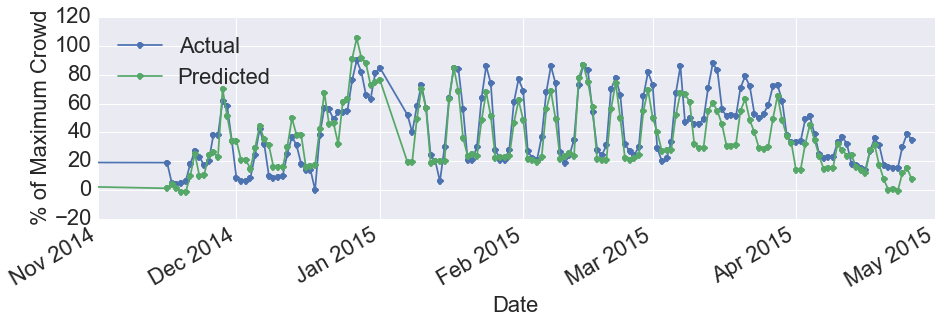

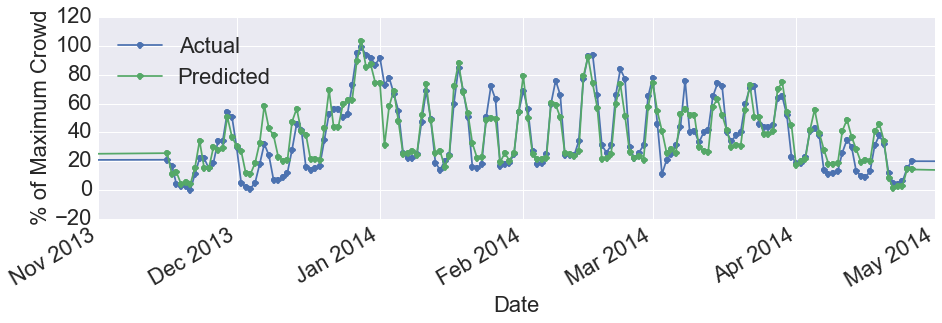

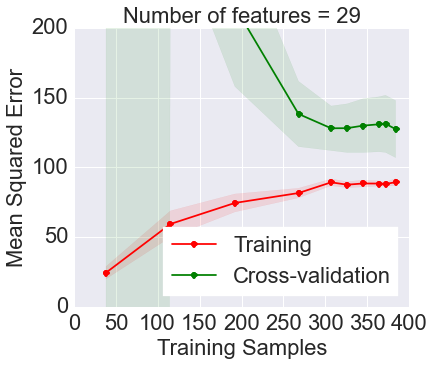

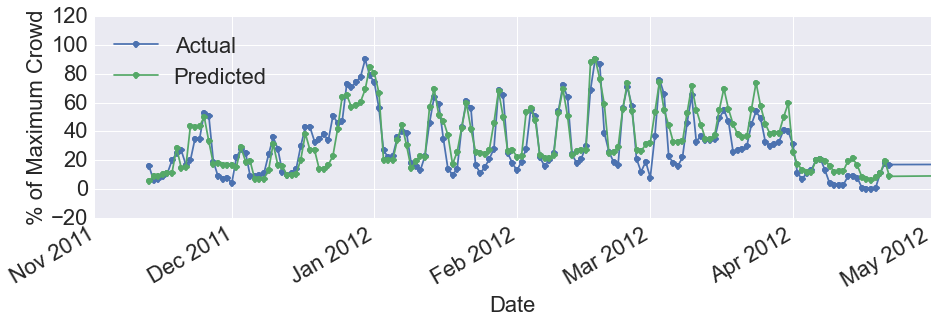

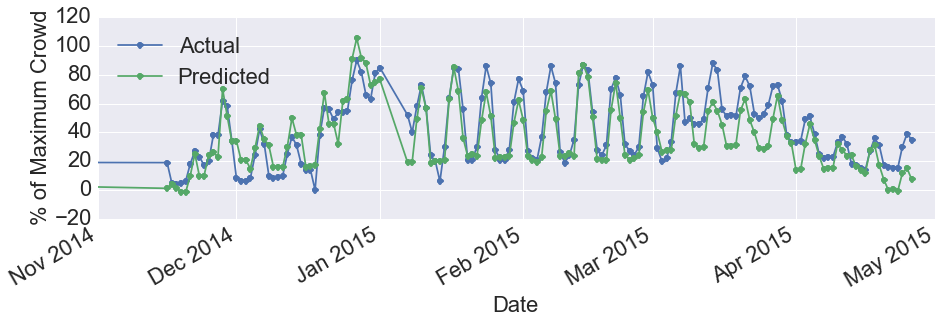

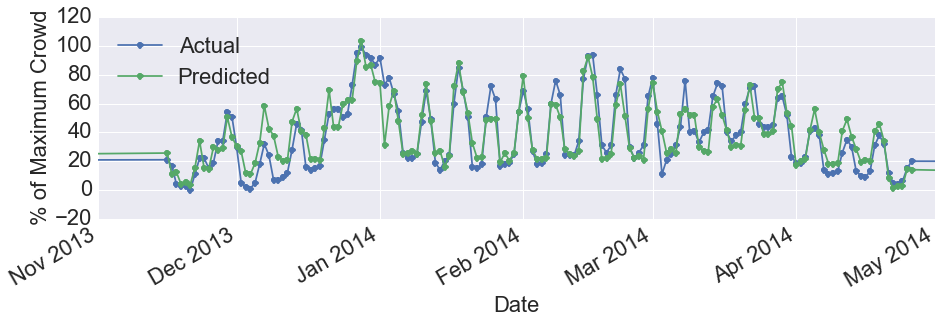

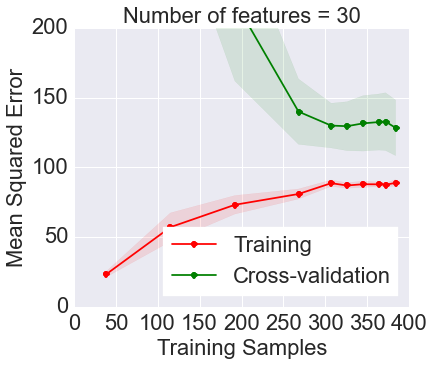

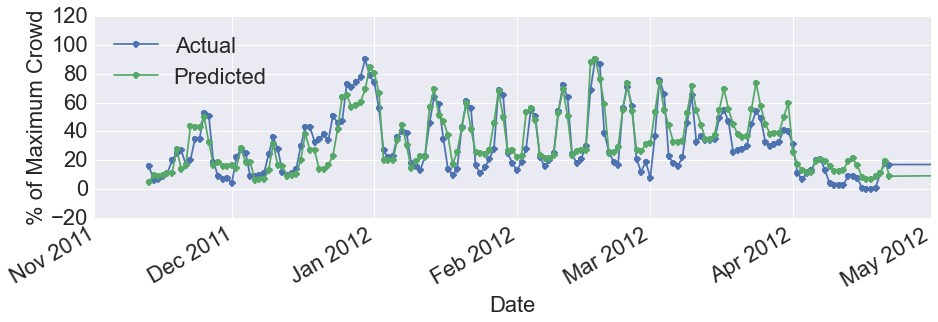

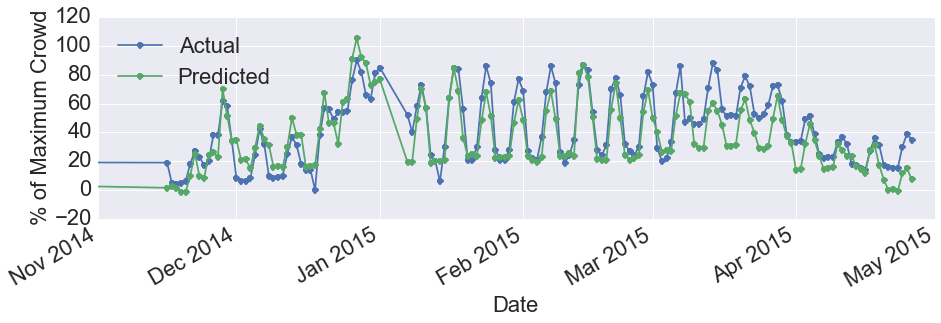

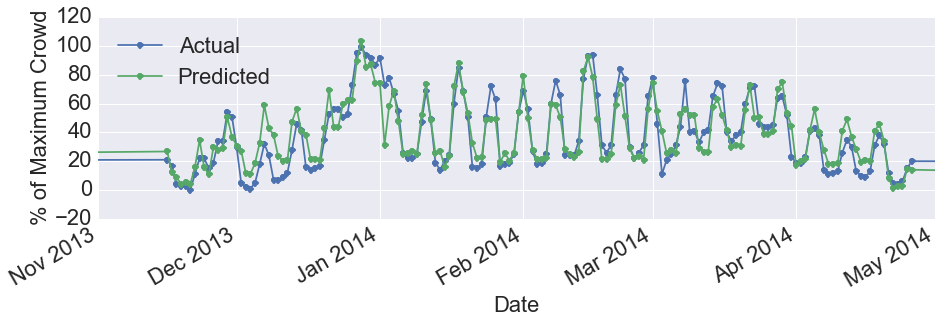

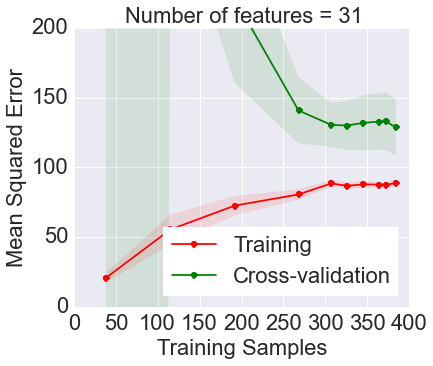

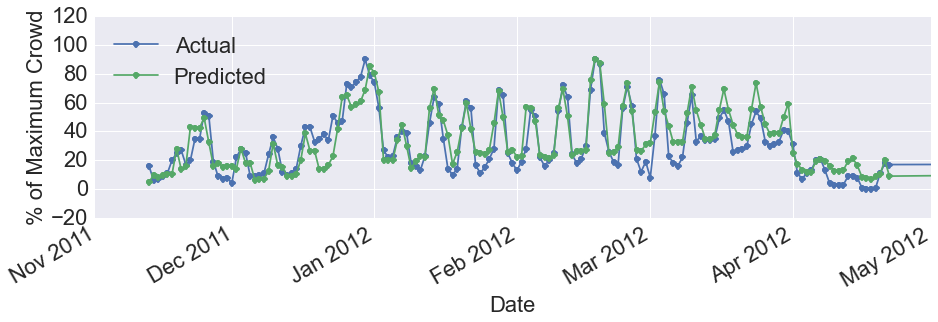

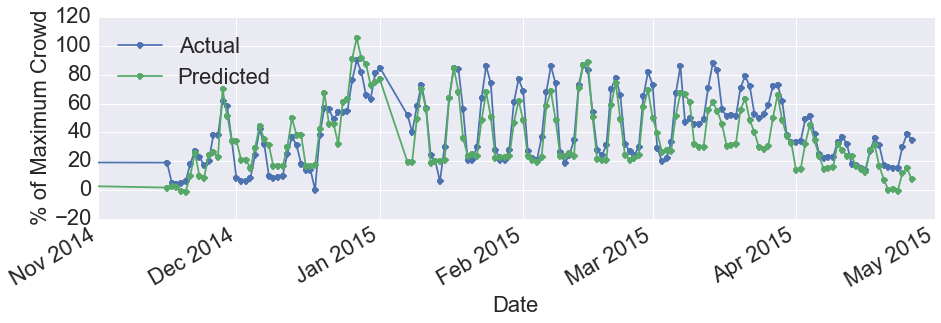

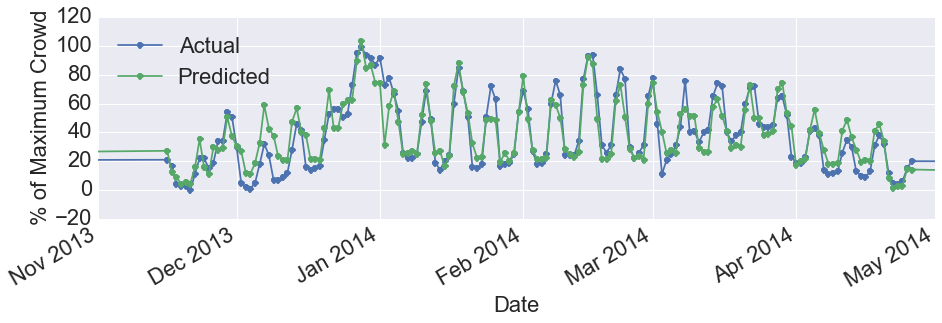

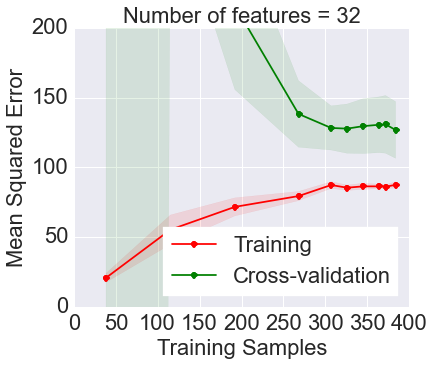

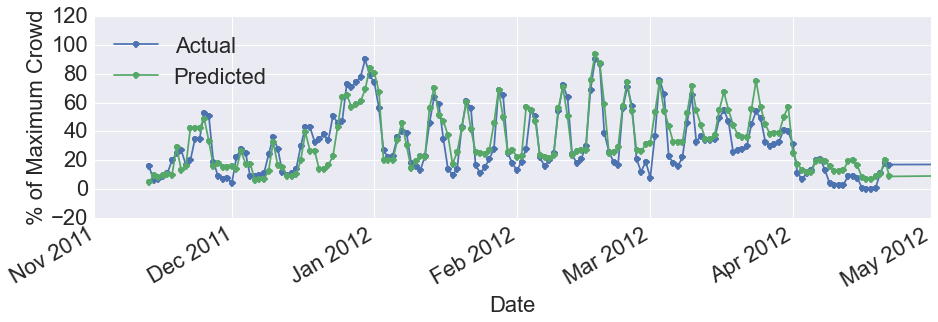

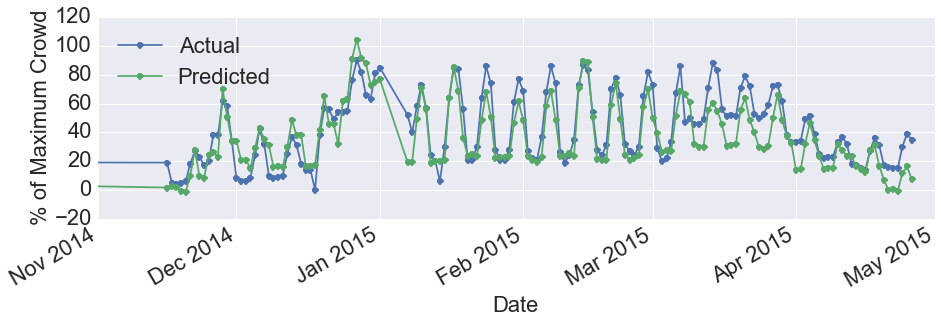

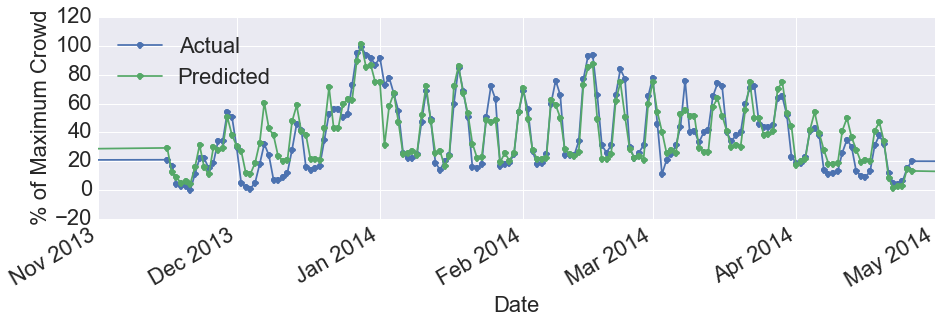

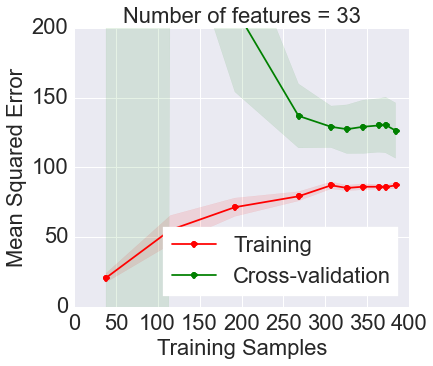

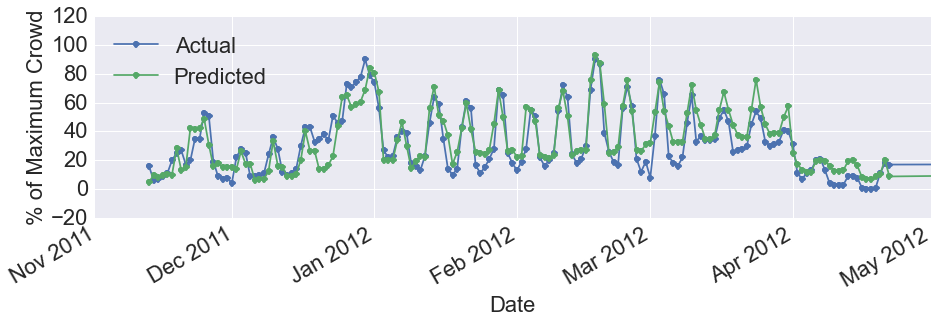

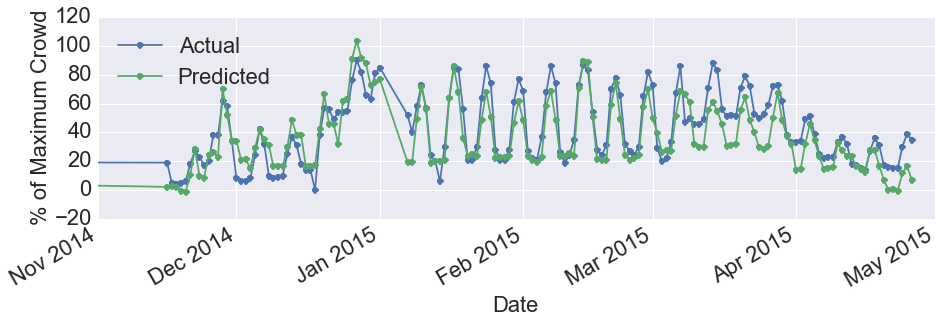

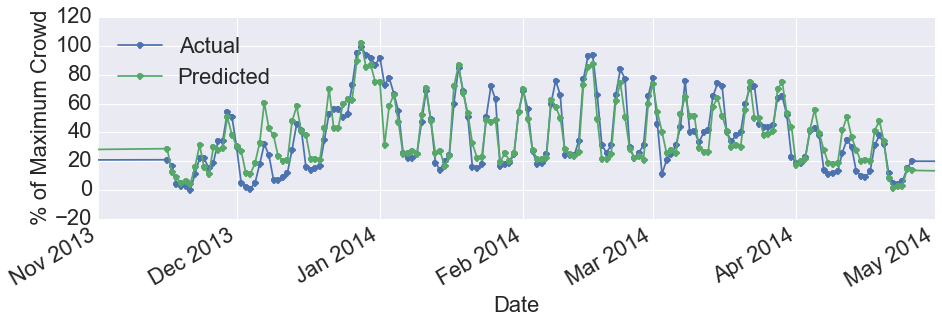

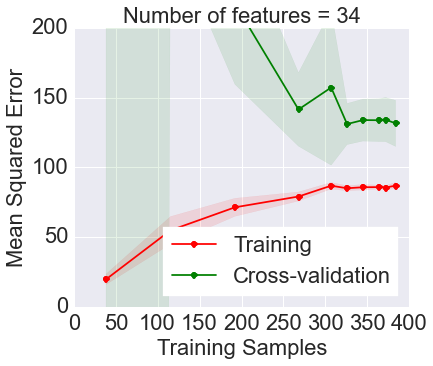

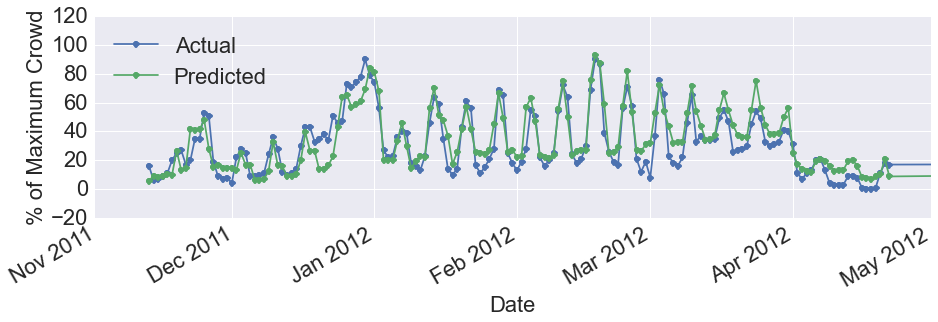

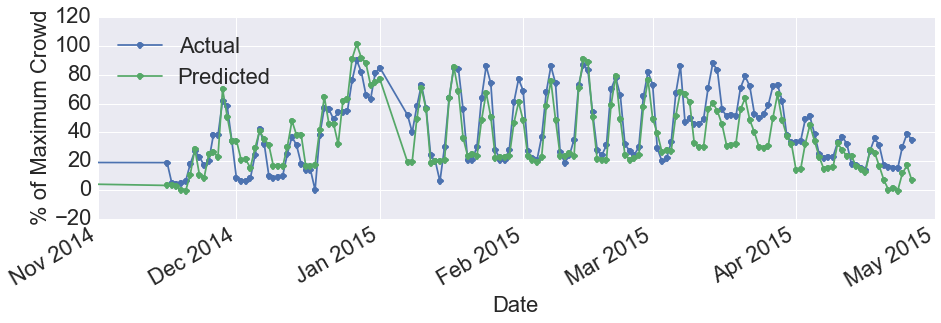

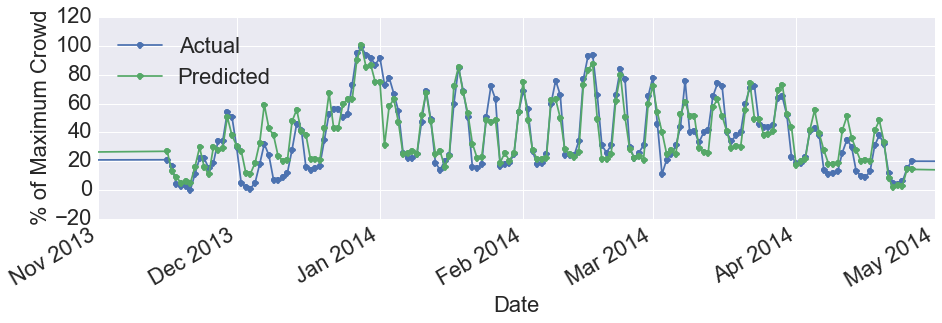

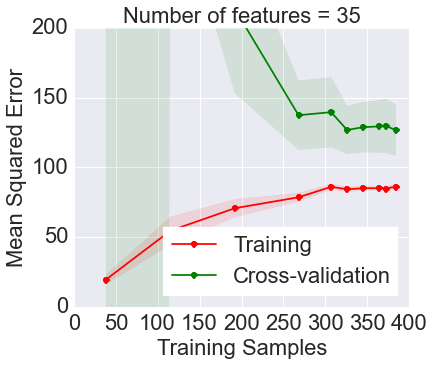

In [178]:
i = 15
while i < 36:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_learning_curve(lin_regr, "Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,200), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

In [179]:
fs_features = ['open_lifts_sq', 'open_percent_midweek_sqrt', 'month_4', 'day_0', 'days_since_start_xmas_sq', 'days_since_start_midweek_sq', 'open_percent', '4day_snow_tot_sat_sqrt', 'month_4_mon', 'day_0_spring_break', '4day_snow_tot_spring_break_sqrt', 'open_trails_mon_sq', 'mlk_day', 'thanksgiv_midweek', 'ln_tot_snow_midweek', 'before_xmas_midweek', '2day_snow_tot_sat', 'thanksgiv_fri', 'pres_day_sat', 'pres_day_fri', 'midweek_xmas', '4day_snow_tot_xmas_sqrt', 'ln_new_24_midweek', 'ln_4day_snow_tot_sat', 'month_4_sat', '6day_snow_tot_sat_sq', 'month_12_sat', 'ln_4day_snow_tot_fri', '6day_snow_tot_fri', 'open_lifts', '6day_snow_tot_xmas', 'midweek_spring_break', 'month_2_midweek', 'pres_day', 'pres_day_midweek']

#### Select the number of features and find the cv and holdout RMSE and predictions.

In [194]:
num_feat = 22
best_features = fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 10.5 ,  Holdout RMSE: 10.0


In [195]:
df_fut = df.ix[datetime.datetime(2015,5,1):]
X_fut = df_fut[best_features]

#### Get bootstrap estimates of confidence intervals to the dataframe.

In [197]:
df_pred = run_bootstrap_model(df_cv, lin_regr, best_features, X_fut, ref_column)

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:688: DeprecationWarning: Bootstrap will no longer be supported as a cross-validation method as of version 0.15 and will be removed in 0.17
  "will be removed in 0.17", DeprecationWarning)


In [198]:
df_fut = add_pred_and_conf_int_to_df(df_pred, df_fut)

functions.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['lower'] = df_fut['pred'] - df_fut['st_dev']*2
functions.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_fut['upper'] = df_fut['pred'] + df_fut['st_dev']*2
functions.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return 

In [199]:
df_fut['resid'] = np.abs(df_fut.skiers - df_fut.pred)

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Cross Validation Fit

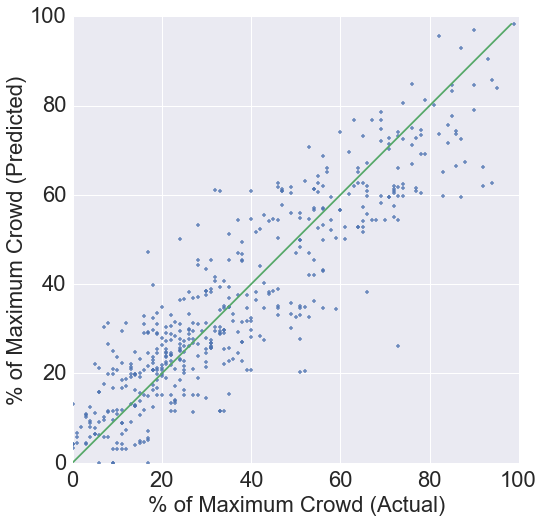

In [200]:
fitted_vs_ref_plot(df_cv_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

### Holdout Fit

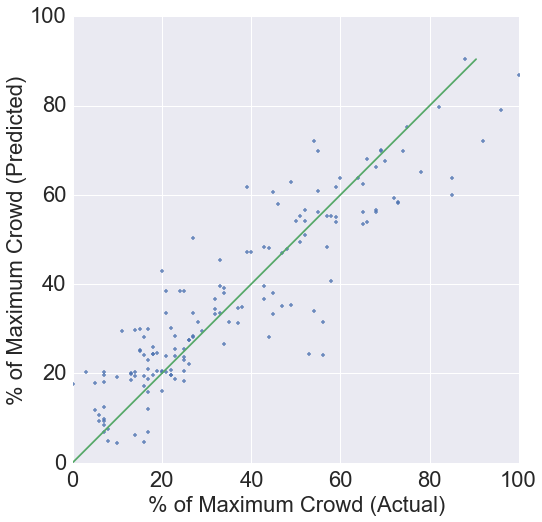

In [201]:
fitted_vs_ref_plot(df_H_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

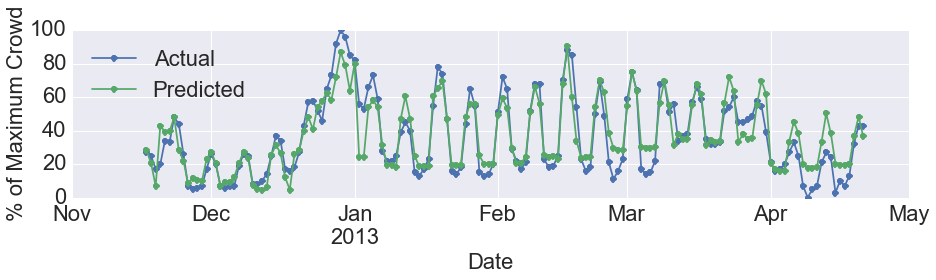

In [202]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1200, (15,3), '% of Maximum Crowd')

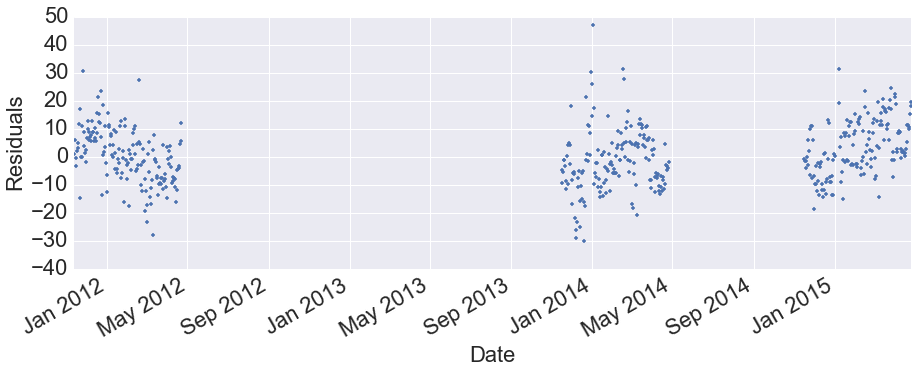

In [203]:
plot_resid_vs_time(df_cv_lin)

### Lasso

In [205]:
features = list(df.columns.values)
features.remove('skiers')

In [206]:
def find_training_and_hold_sets(df_tr, df_h, features):
    X_tr = df_tr[features]
    y_tr = df_tr.skiers.values
    X_h = df_h[features]
    y_h = df_h.skiers.values
    return X_tr, y_tr, X_h, y_h

In [207]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features)

In [ ]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

In [ ]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [ ]:
clf = linear_model.Lasso(alpha=best_lambda)

In [ ]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

#### Plot the holdout lasso prediction vs the reference data

In [ ]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [ ]:
features = fs_features

In [ ]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

#### Fit the random forest regressor and find cross-validation stats

In [ ]:
rfr = RandomForestRegressor(n_estimators = 150, oob_score = True, n_jobs = -1)

In [ ]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

In [ ]:
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5))

In [ ]:
plot_fitted_and_ref_vs_time(df_rf_hold, 'skiers', ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE_rf_H, (15,5))

# Export Data

In [204]:
df_fut.to_csv('../webpage_ski/df_all_features.csv')